In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import datetime
import os
#print(os.listdir("../input"))

import time

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Any results you write to the current directory are saved as output.

In [2]:
# modelling imports
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import (accuracy_score, f1_score, precision_score, 
auc, recall_score, roc_curve, roc_auc_score)
from sklearn.metrics import confusion_matrix, classification_report
from imblearn.over_sampling import SMOTE, ADASYN, RandomOverSampler
from sklearn.ensemble import RandomForestClassifier

import xgboost as xgb

The evaluator for this Kaggle competition will be area under the ROC curve, AUC. Given the fact that this data is so imbalanced, I will focus on F1 to guide the accuracy of my models. 

In [3]:
!pwd

/Users/josephpope/GitHub/McNulty - Kaggle App Fraud


In [4]:
print(os.listdir("/Users/josephpope/GitHub/McNulty - Kaggle App Fraud/data/"))

['test.csv', 'test_supplement.csv', 'train.csv', 'sample_submission.csv']


In [5]:
test_path = "/Users/josephpope/GitHub/McNulty - Kaggle App Fraud/data/test.csv"
train_path = "/Users/josephpope/GitHub/McNulty - Kaggle App Fraud/data/train.csv"

In [6]:
# seaborn settings 

sns.set(rc={'figure.figsize':(10,4)});
plt.figure(figsize=(10,4));

In [7]:
print(sns.__version__)

0.9.0


In [8]:
test = pd.read_csv(test_path, nrows=2000000)

In [9]:
test.head()

,click_id,ip,app,device,os,channel,click_time
0,0,5744,9,1,3,107,2017-11-10 04:00:00
1,1,119901,9,1,3,466,2017-11-10 04:00:00
2,2,72287,21,1,19,128,2017-11-10 04:00:00
3,3,78477,15,1,13,111,2017-11-10 04:00:00
4,4,123080,12,1,13,328,2017-11-10 04:00:00


In [10]:
test.dtypes

click_id       int64
ip             int64
app            int64
device         int64
os             int64
channel        int64
click_time    object
dtype: object

In [11]:
train = pd.read_csv(train_path, nrows=2000000, parse_dates=True, infer_datetime_format=True, 
                    date_parser = pd.to_datetime)

In [12]:
train.head(1)

,ip,app,device,os,channel,click_time,attributed_time,is_attributed
0,83230,3,1,13,379,2017-11-06 14:32:21,NaN,0


In [13]:
train.nunique()

ip                 47468
app                  255
device               425
os                   197
channel              155
click_time          3411
attributed_time     3018
is_attributed          2
dtype: int64

# DATA CLEAN UP AND FEATURE ENGINEERING

In [14]:
# store temporal data as datetime on train and test sets

train['click_time'] = pd.to_datetime(train['click_time'])
test['click_time'] = pd.to_datetime(test['click_time'])

In [15]:
train['attributed_time'] = pd.to_datetime(train['attributed_time'])

In [16]:
# the postive class ('1', downloaded app) is a teeny, tiny fraction of the negative class 

train['is_attributed'].value_counts()

0    1996612
1       3388
Name: is_attributed, dtype: int64

In [17]:
train.head(1)

,ip,app,device,os,channel,click_time,attributed_time,is_attributed
0,83230,3,1,13,379,2017-11-06 14:32:21,NaT,0


In [18]:
# overall conversion rate -- to get a sense of the inherent class imbalance 

conv_rate = train.is_attributed.sum() / len(train)
print('{:.02%}'.format(conv_rate))

0.17%


In [19]:
#WOE = In(% of non-events ➗ % of events)

np.log((1-conv_rate) / conv_rate)

6.3789672463118254

In [20]:
train.columns

Index(['ip', 'app', 'device', 'os', 'channel', 'click_time', 'attributed_time',
       'is_attributed'],
      dtype='object')

In [21]:
user_agent = ['ip','app','device','os','channel']

In [22]:
# concatenate all computer related features into one string for data exploration purposes. 
# we should be reasonably certain that each user agent is one unique individual. 
# click time and attributed time may help shed further light here. 

train['user_agent'] = train[user_agent].apply(lambda x: '.'.join(x.astype(str)), axis=1)

In [23]:
# set all non-time related fields as 'categorical' 

# for u in user_agent:
#     train[u] = train[u].astype('category')
# #train['is_attributed'] = train['is_attributed'].astype('category')
# train['user_agent'] = train['user_agent'].astype('category')

In [24]:
train.dtypes

ip                          int64
app                         int64
device                      int64
os                          int64
channel                     int64
click_time         datetime64[ns]
attributed_time    datetime64[ns]
is_attributed               int64
user_agent                 object
dtype: object

In [25]:
# break out click datetime object into seconds, minutes, hours and days

train['day'] = train['click_time'].dt.day.astype('uint8')
train['hour'] = train['click_time'].dt.hour.astype('uint8')
train['minute'] = train['click_time'].dt.minute.astype('uint8')
train['second'] = train['click_time'].dt.second.astype('uint8')

In [26]:
train.head(1)

,ip,app,device,os,channel,click_time,attributed_time,is_attributed,user_agent,day,hour,minute,second
0,83230,3,1,13,379,2017-11-06 14:32:21,NaT,0,83230.3.1.13.379,6,14,32,21


In [27]:
train.dtypes

ip                          int64
app                         int64
device                      int64
os                          int64
channel                     int64
click_time         datetime64[ns]
attributed_time    datetime64[ns]
is_attributed               int64
user_agent                 object
day                         uint8
hour                        uint8
minute                      uint8
second                      uint8
dtype: object

In [28]:
# here we can see one user agent has 36 hits when nrows=100000.   
# let's explore this further 

train.user_agent.value_counts()[:5]

172209.2.1.14.477    507
73487.12.1.19.326    371
73487.3.1.19.153     362
73516.3.1.19.153     361
73516.12.1.19.326    343
Name: user_agent, dtype: int64

In [29]:
train['download_time'] = train['attributed_time'] - train['click_time']
train[~train['download_time'].isnull()];

In [30]:
train['download_time_seconds'] = train['download_time'].astype('timedelta64[s]')
train['download_time_minutes'] = train['download_time'].astype('timedelta64[m]')
train['download_time_hours'] = train['download_time'].astype('timedelta64[h]')

In [31]:
train.head(1)

,ip,app,device,os,channel,click_time,attributed_time,is_attributed,user_agent,day,hour,minute,second,download_time,download_time_seconds,download_time_minutes,download_time_hours
0,83230,3,1,13,379,2017-11-06 14:32:21,NaT,0,83230.3.1.13.379,6,14,32,21,NaT,NaN,NaN,NaN


In [32]:
attributed = train[train['is_attributed'] == 1]

In [33]:
attributed['download_time'].describe()

count                      3388
mean     0 days 05:39:15.929161
std      0 days 06:54:53.142986
min             0 days 00:00:00
25%             0 days 00:01:58
50%      0 days 00:55:44.500000
75%             0 days 10:15:17
max             0 days 23:52:38
Name: download_time, dtype: object

In [34]:
# we see NONE of our user agents for the attributed data have more than 
# one hit. compare against the non-attributed value_counts, where 
# we saw over 20+ hits for a single user-agent, a sure sign of fraud. 
attributed.user_agent.value_counts();

In [35]:
attributed.head(1)

,ip,app,device,os,channel,click_time,attributed_time,is_attributed,user_agent,day,hour,minute,second,download_time,download_time_seconds,download_time_minutes,download_time_hours
103,204158,35,1,13,21,2017-11-06 15:41:07,2017-11-07 08:17:19,1,204158.35.1.13.21,6,15,41,7,16:36:12,59772.0,996.0,16.0


In [36]:
attributed.shape

(3388, 17)

In [37]:
tmp = train.groupby('user_agent')['user_agent'].count().to_frame('click_count').reset_index()

In [38]:
tmp.sort_values('click_count', ascending=False)[:10]

,user_agent,click_count
366129,172209.2.1.14.477,507
910311,73487.12.1.19.326,371
911712,73487.3.1.19.153,362
914204,73516.3.1.19.153,361
912833,73516.12.1.19.326,343
265571,14320.8.1.19.145,321
577936,30433.8.1.19.145,318
366603,172352.8.1.8.145,315
856049,66564.8.1.19.145,312
446871,193061.8.1.13.145,312


In [39]:
train = train.merge(tmp, how='left')
del tmp

# BUILD BASELINE MODEL 

In [40]:
# fillna and handle all #NAs 

nas = ['attributed_time', 'download_time', 'download_time_hours', 'download_time_minutes',
       'download_time_seconds']

In [41]:
train = train.fillna('0')

In [42]:
train.dtypes

ip                                 int64
app                                int64
device                             int64
os                                 int64
channel                            int64
click_time                datetime64[ns]
attributed_time           datetime64[ns]
is_attributed                      int64
user_agent                        object
day                                uint8
hour                               uint8
minute                             uint8
second                             uint8
download_time            timedelta64[ns]
download_time_seconds             object
download_time_minutes             object
download_time_hours               object
click_count                        int64
dtype: object

In [43]:
train.head(1)

,ip,app,device,os,channel,click_time,attributed_time,is_attributed,user_agent,day,hour,minute,second,download_time,download_time_seconds,download_time_minutes,download_time_hours,click_count
0,83230,3,1,13,379,2017-11-06 14:32:21,1970-01-01,0,83230.3.1.13.379,6,14,32,21,0 days,0,0,0,1


In [44]:
# prepare X and y for train, test splits and CV 

y = train['is_attributed']
X = train.drop(['ip', 'is_attributed','click_time','attributed_time','download_time'], axis=1).select_dtypes(include=[np.number])

In [45]:
X.head(1)

,app,device,os,channel,day,hour,minute,second,click_count
0,3,1,13,379,6,14,32,21,1


In [46]:
X.dtypes

app            int64
device         int64
os             int64
channel        int64
day            uint8
hour           uint8
minute         uint8
second         uint8
click_count    int64
dtype: object

In [47]:
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size = 0.2, random_state=44)

In [48]:
X.shape, y.shape, X_train.shape, X_test.shape, y_train.shape, y_test.shape

((2000000, 9), (2000000,), (1600000, 9), (400000, 9), (1600000,), (400000,))

In [49]:
# log_predictions = lr.predict(X_test)
# logit_score = accuracy_score(y_test, log_predictions)
# print(logit_score)

### SUMMARY STATS FUNCTION 

In [50]:
def summary_stats(model, X_train=X_train, y_train=y_train, 
                  X_test=X_test, y_test=y_test):
    '''
    input model (linear regression, random forest), X_test and y_test
    '''
    model.fit(X_train, y_train)
    
    try: 
        prob_y = model.predict_proba(X_test)
        prob_y = [p[1] for p in prob_y]
    except: 
        pass
    
    p = model.predict(X_test)
    
    print("ROC Score: {:.04f}\nRecall Score: {:.04f}\n\
Accuracy Score: {:.04f}\nMisclassification Rate: {:04f}\n\
Precision Score: {:.04f}\nF1 Score: {:.04f}\n"
          .format(roc_auc_score(y_test, prob_y),
                  recall_score(y_test,p),
                  accuracy_score(y_test,p),
                  1-accuracy_score(y_test,p),
                  precision_score(y_test,p),
                  f1_score(y_test,p)))
    
    print(confusion_matrix(y_test, p))
    
    print("\n")
    
    print(classification_report(y_test, p))

In [ ]:
confusion_matrix(y_test, model.predict(X_test))

#### SMOTE

### XGBoost

In [51]:
# scale_pos_weight -- important for imbalanced class problems 
# https://www.kaggle.com/nanomathias/feature-engineering-importance-testing

In [52]:
feature_names = X_train.columns

In [53]:
X_train = pd.DataFrame(data=X_train, columns=feature_names)
X_test = pd.DataFrame(data=X_test, columns=feature_names)

In [54]:
watchlist = [(xgb.DMatrix(X_train, y_train), 'train'), (xgb.DMatrix(X_test, y_test), 'valid')]

In [55]:
params = {'eta': .3,
          'max_depth': 4, 
          'subsample': 0.9,
          'n_estimators': 100, 
          'colsample_bytree': 0.7,
          'colsample_bylevel': 0.7,
          'scale_pos_weight': 200,
          'min_child_weight': 200,
          'reg_alpha': 4,
          'n_jobs': 4, 
          'objective': 'binary:logistic',
          'reg_lambda': 1,
          'seed': 44,
          'max_delta_step': 1}

In [56]:
feature_names = X_train.columns

In [57]:
gbm = xgb.XGBClassifier(**params)

eval_set=[(X_train,y_train),(X_test,y_test)] #tracking train/validation error as we go
fit_model = gbm.fit( 
                    X_train, y_train, 
                    eval_set=eval_set,
                    eval_metric='auc',
                    early_stopping_rounds=50,
                    verbose=True #gives output log as below
                   )

[0]	validation_0-auc:0.854483	validation_1-auc:0.851298
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 50 rounds.
[1]	validation_0-auc:0.85654	validation_1-auc:0.858642
[2]	validation_0-auc:0.858858	validation_1-auc:0.863235
[3]	validation_0-auc:0.890076	validation_1-auc:0.896759
[4]	validation_0-auc:0.888992	validation_1-auc:0.89617
[5]	validation_0-auc:0.892513	validation_1-auc:0.900526
[6]	validation_0-auc:0.892946	validation_1-auc:0.901182
[7]	validation_0-auc:0.892061	validation_1-auc:0.898732
[8]	validation_0-auc:0.902005	validation_1-auc:0.90647
[9]	validation_0-auc:0.904763	validation_1-auc:0.911051
[10]	validation_0-auc:0.904226	validation_1-auc:0.910328
[11]	validation_0-auc:0.907601	validation_1-auc:0.912968
[12]	validation_0-auc:0.909507	validation_1-auc:0.915389
[13]	validation_0-auc:0.909903	validation_1-auc:0.915935
[14]	validation_0-auc:0.909255	validation_1-auc:0.914327
[

In [58]:
clf_xgBoost = xgb.XGBClassifier(**params)

In [59]:
summary_stats(clf_xgBoost)

ROC Score: 0.9548
Recall Score: 0.7426
Accuracy Score: 0.9896
Misclassification Rate: 0.010413
Precision Score: 0.1165
F1 Score: 0.2013

[[395310   3983]
 [   182    525]]


             precision    recall  f1-score   support

          0       1.00      0.99      0.99    399293
          1       0.12      0.74      0.20       707

avg / total       1.00      0.99      0.99    400000



In [71]:
def print_confusion_matrix(confusion_matrix, class_names, figsize = (10,7), fontsize=14):
    """Prints a confusion matrix, as returned by sklearn.metrics.confusion_matrix, as a heatmap.
    
    Arguments
    ---------
    confusion_matrix: numpy.ndarray
        The numpy.ndarray object returned from a call to sklearn.metrics.confusion_matrix. 
        Similarly constructed ndarrays can also be used.
    class_names: list
        An ordered list of class names, in the order they index the given confusion matrix.
    figsize: tuple
        A 2-long tuple, the first value determining the horizontal size of the ouputted figure,
        the second determining the vertical size. Defaults to (10,7).
    fontsize: int
        Font size for axes labels. Defaults to 14.
        
    Returns
    -------
    matplotlib.figure.Figure
        The resulting confusion matrix figure
    """
    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names, 
    )
    fig = plt.figure(figsize=figsize)
    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d")
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    return fig

In [73]:
conf = confusion_matrix(y_test, clf_xgBoost.predict(X_test))

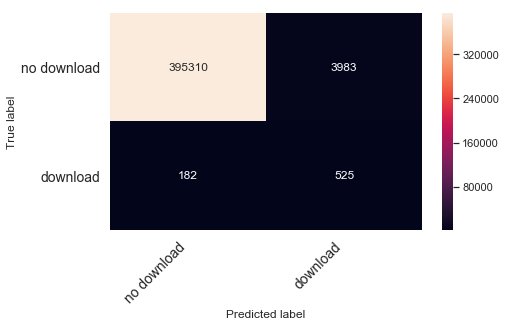

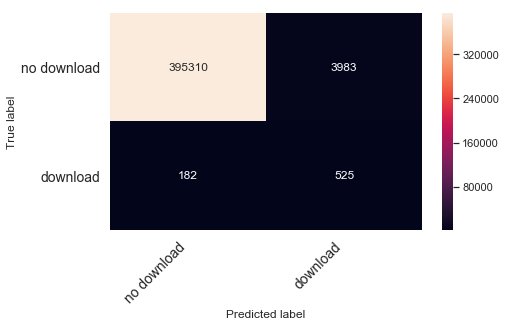

In [77]:
print_confusion_matrix(conf, ['no download','download'], figsize=(7,4))

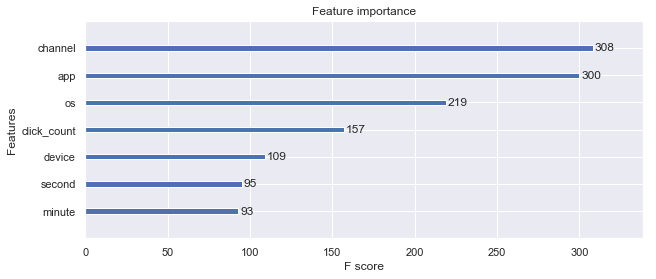

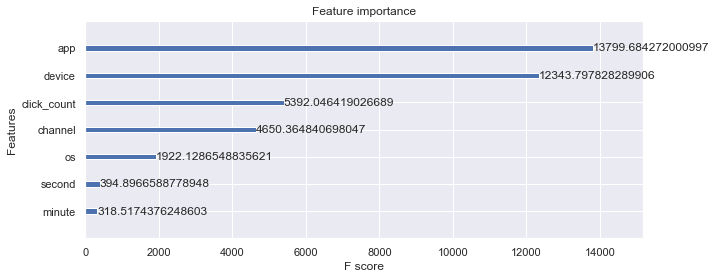

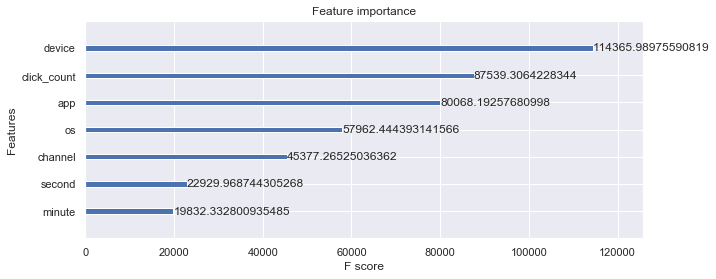

In [60]:
xgb.plot_importance(clf_xgBoost, importance_type='weight');
xgb.plot_importance(clf_xgBoost, importance_type='gain');
xgb.plot_importance(clf_xgBoost, importance_type='cover');

In [61]:
dtrain = xgb.DMatrix(X_train.values, y_train.values)

In [62]:
res = xgb.cv(params=params, dtrain=dtrain, num_boost_round=2, folds=5, 
             verbose_eval=True)

[0]	train-error:0.00889733+0.000657835	test-error:0.008921+0.000649346
[1]	train-error:0.00657433+0.000757077	test-error:0.00658233+0.0007594


In [63]:
train.to_csv('kaggle_data2.csv', index=False)